## This notebook contains the code used to merge and analyze 
## the Weather (NOAA_df) and Downed Aircraft (downed_df) datasets.

In [1]:
# Import the following libraries:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import the cleaned dataframes
from NOAA import get_cleaned_NOAA_df
from reason_data import downed 

In [2]:
# Assign the dataframes to begin and sort by datetime columns
downed_df = downed().sort_values('downed')
NOAA_df = get_cleaned_NOAA_df().sort_values('DATE')

# Quick look at the data size for reference
print("downed_df: ", downed_df.shape)
print("NOAA_df: ", NOAA_df.shape)

downed_df:  (900, 6)
NOAA_df:  (11897, 19)


# Merge downed_df and NOAA_df
The NOAA data contains multiple lines per day.  In order to limit lines from downed_df being duplicated after the merge,
use the **pandas.merge_asof** method.<br>This will merge the downed_df on the nearest prior datetime as the NOAA_df.

In [3]:
def merge_downed_and_NOAA():
    # Merge and assign each downed event the most recent NOAA data before that event
    # merge_asof is like a left-join but matches on the nearest key rather than the equal keys. 
   
    merged_df = pd.merge_asof(
        downed_df,
        NOAA_df,
        left_on='downed',
        right_on='DATE',
        direction='backward'
    )
    print(merged_df.shape) # the number of rows in merged_df should match downed_df if done correctly
    return merged_df
merged_df = merge_downed_and_NOAA()

(900, 25)


Check if there are still rows in merged_df that contain NaNs

In [4]:
nan_rows = merged_df[merged_df['DATE'].isna()]
# df = merged_df.drop(nan_rows.index)
nan_rows['downed']

0   2019-09-25 07:11:00
1   2022-03-28 10:38:00
2   2023-08-24 14:27:00
3   2023-09-20 10:47:00
4   2023-09-20 11:57:00
5   2023-10-26 09:09:00
6   2023-12-12 12:04:00
7   2023-12-21 11:18:00
8   2023-12-21 16:33:00
Name: downed, dtype: datetime64[ns]

There are some, but all of these events began prior to the NOAA data, so remove these rows.<br>

Also, the **reason** column in **downed_df** contains the general maintenance reason an aircraft was downed (grounded).<br>
Some of the reasons (**50 hour**, **100 hour**, and **Annual inspections**) occur on a schedule, and the Unspecified<br> 
reasons don't give any specific indications, so all those can be removed from analysis.

In [5]:
def clean_merged_df(merged_df):
    nan_rows = merged_df[merged_df['DATE'].isna()]
    merged_df = merged_df.drop(nan_rows.index)
    merged_df = merged_df.loc[merged_df['reason'].isin(['50 Hr Inspect','100 Hr Inspect','Annual Inspect','Unspecified']) == False]
    
    merged_df = merged_df.reset_index(drop=True)
    return merged_df
     
NOAA_downed_df = clean_merged_df(merged_df)
NOAA_downed_df.head()

,resource,downed,upped,duration,reason,reported duration,DATE,altimeter,dew_point,temperature,...,wind_speed,avg_altimeter_prev_5d,avg_dew_point_prev_5d,avg_temperature_prev_5d,avg_precipitation_prev_5d,avg_humidity_prev_5d,avg_visibility_prev_5d,avg_wind_dir_prev_5d,avg_gust_speed_prev_5d,avg_wind_speed_prev_5d
0,WMU34 N57JW,2024-01-04 11:40:00,2024-01-04 15:20:00,0 days 03:40:00,Avionics,0 days 03:42:00,2024-01-04 10:53:00,30.34,14.0,27.0,...,6.0,30.101452,26.903226,32.016129,0.000847,81.935484,8.727823,246.733871,21.260702,9.403226
1,WMU51 N923JW,2024-01-16 15:27:00,2024-01-19 09:17:00,2 days 17:50:00,Avionics,2 days 17:48:00,2024-01-16 15:06:00,29.97,-4.0,5.0,...,16.0,29.678063,11.834507,16.866197,0.009756,80.411972,4.592870,216.971831,28.160753,16.957746
2,WMU44 N80GD,2024-01-17 16:22:00,2024-01-18 08:56:00,0 days 16:34:00,Airframe,0 days 16:36:00,2024-01-17 15:53:00,29.89,5.0,16.0,...,17.0,29.698453,7.892086,13.435252,0.008615,78.377698,4.683903,226.402878,28.433671,17.863309
3,WMU52 N851ST,2024-01-19 15:39:00,2024-01-21 12:49:00,1 days 21:10:00,Engine,1 days 21:12:00,2024-01-19 15:23:00,30.10,11.0,21.0,...,7.0,30.009378,5.280000,11.622222,0.002933,75.617778,6.722222,218.044444,25.813721,11.182222
4,WMU42 N94RS,2024-01-20 15:23:00,2024-01-21 12:20:00,0 days 20:57:00,Engine,0 days 21:00:00,2024-01-20 14:53:00,30.35,14.0,24.0,...,16.0,30.027588,7.456140,13.675439,0.002895,76.280702,6.629386,210.350877,26.863577,9.978070


### NOAA_downed_df is ready to analyze.


Assign some variables to help with building charts.

|Variable |Description |
|:--- |:--- |
| reason_counts | Frequency of aircraft downed reasons |
| reasons_terms | Names of each reason |
| aircraft_counts | Frequency of each aircraft being downed |
| avg_cols | NOAA columns that contain previous 5 day averages |

In [6]:
# define a function that returns variables for future use
def get_merged_data():

    reason_counts = NOAA_downed_df['reason'].value_counts()
    reasons_terms = NOAA_downed_df['reason'].unique().tolist()
    aircraft_counts = NOAA_downed_df['resource'].value_counts()    
    avg_cols = [col for col in NOAA_downed_df.columns if col.startswith('avg')]

    return reason_counts, reasons_terms, aircraft_counts, avg_cols
reason_counts, reasons_terms, aircraft_counts, avg_cols = get_merged_data()

# Visualizations

To keep colors consistent, define a color palette that will assign each downed reason a color

In [7]:
def custom_palette(color):
    palette = sns.color_palette(color, n_colors=len(reasons_terms))
    our_colors = dict(zip(reasons_terms, palette))
    return our_colors
our_colors = custom_palette('Pastel1')
# use our_colors for categorical charts

Use Seaborn's **kdeplot** to see how a weather condition effects all of the downed reasons in one chart

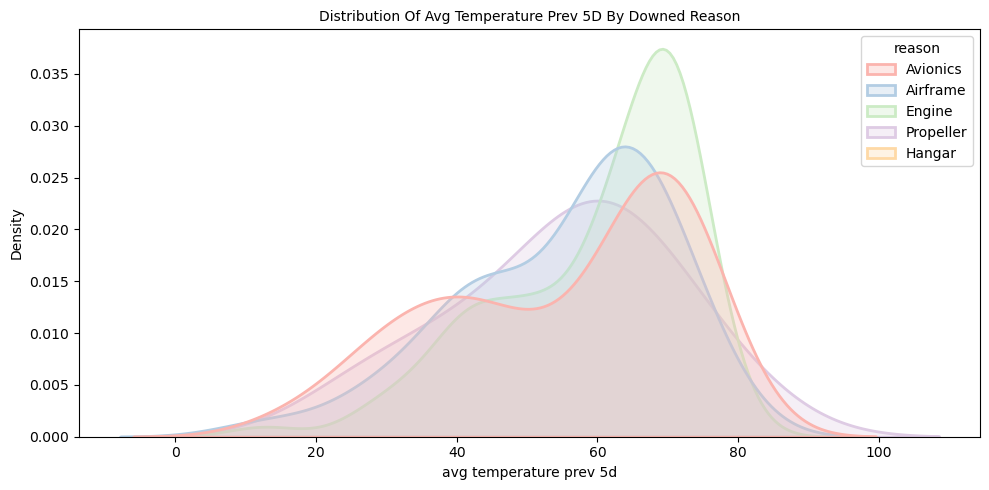

In [8]:
# # KDE plot template for weather data in final_merged_df
# # Use this function for any/all weather features to get a closer look.
def plot_kde_by_reason(x):
    sub_df = NOAA_downed_df[[x, 'reason']].dropna()

    fig = plt.figure(figsize=(10, 5))
    sns.kdeplot(
        data=sub_df,
        x=x,
        hue='reason',
        fill=True,
        common_norm=False,
        alpha=0.3,
        linewidth=2,
        palette=our_colors
    )
    x = x.replace('_', ' ')
    plt.title((f'Distribution of {x} by Downed Reason').title(), fontsize=10)
    plt.xlabel(x)
    plt.ylabel('Density')
    plt.tight_layout()
    return fig
plot_kde_by_reason('avg_temperature_prev_5d'); #the semicolon prevents jupyter from automagically displaying the chart 

### Maybe there is a relation between downed events and weather conditions.

Start with Seaborn's **kdeplot** to overlay downed reason for each weather condition.

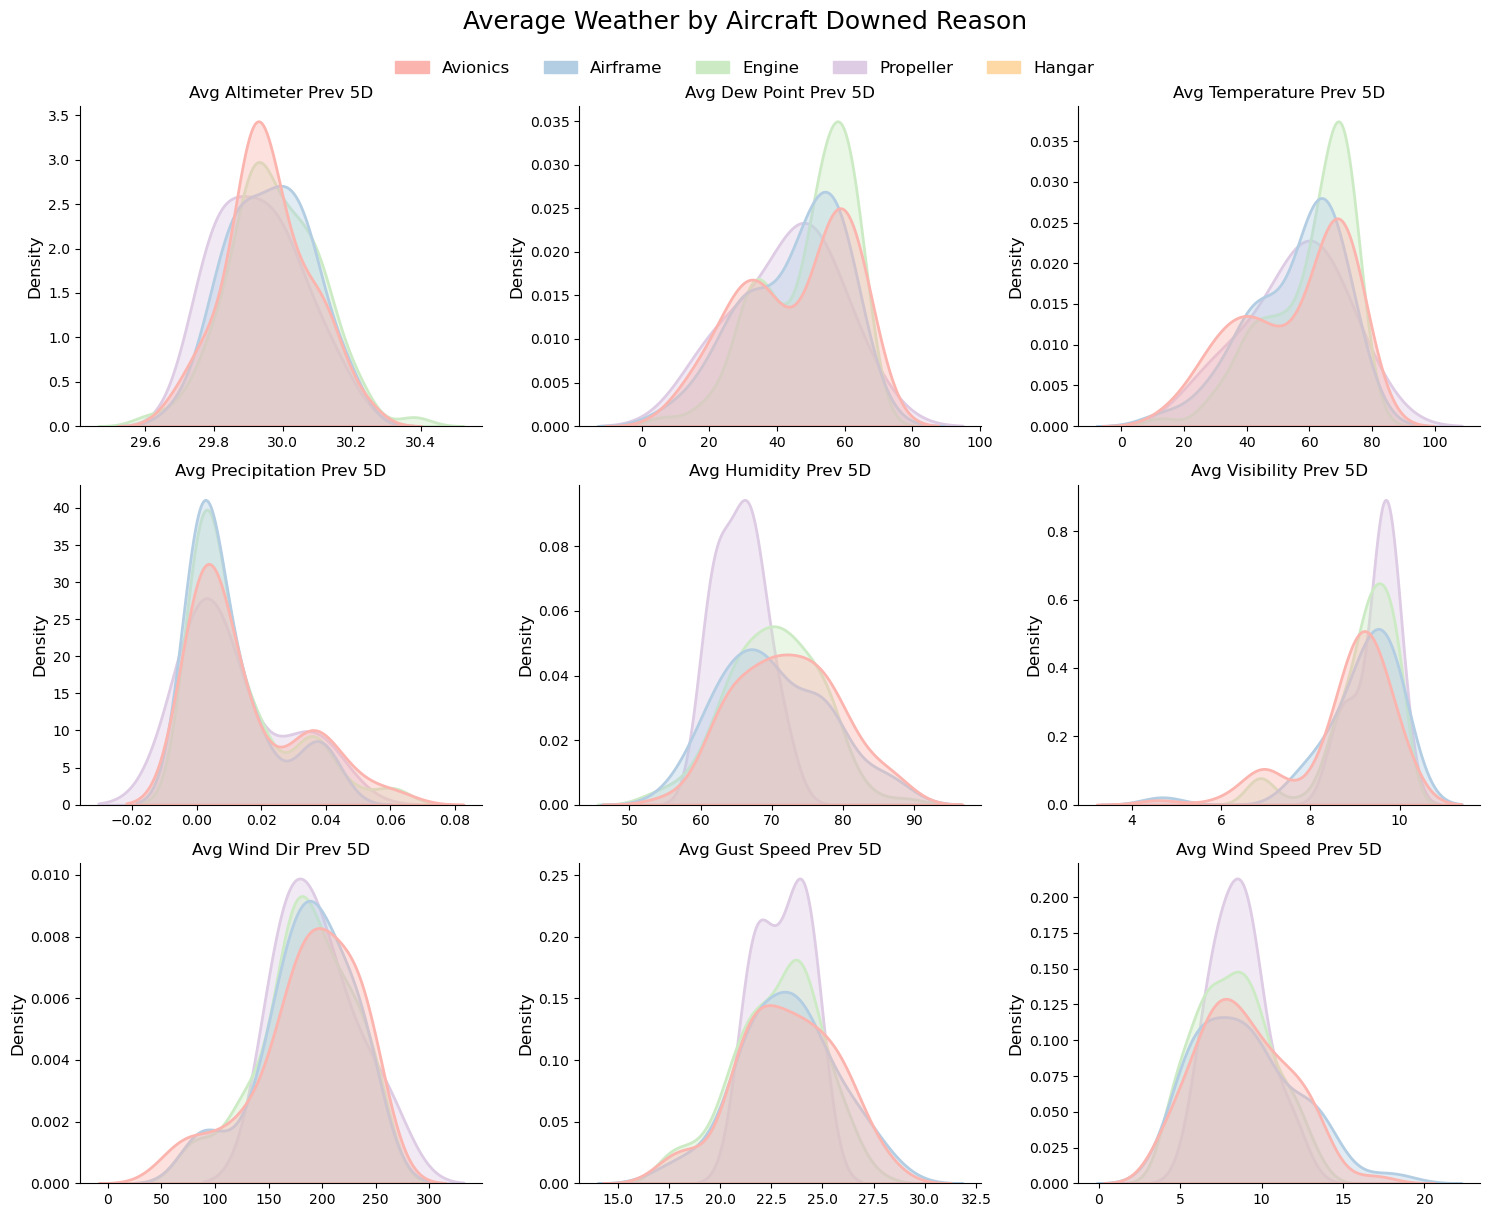

In [15]:
# KDE plot for weather data in NOAA_downed_df
# Use this function to build a grid of KDEs for all weather features.

def plot_kde_grid():
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    #
    for i, col in enumerate(avg_cols):
        sub_df = NOAA_downed_df[[col, 'reason']].dropna()
      
        sns.kdeplot(
            data=sub_df,
            x=col,
            hue='reason',
            fill=True,
            common_norm=False,
            alpha=0.4,
            linewidth=2,
            palette=our_colors,
            ax=axes[i],
            legend=False # Don't display a legend on every subplot. See below fig.legend
        )
     
        # Clean up the subplot titles by replacing underscores with spaces
        axes[i].set_title(col.replace('_', ' ').title(), fontsize=12) 
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density', fontsize=12)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
    
    fig.suptitle("Average Weather by Aircraft Downed Reason", fontsize=18, y=1.01)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)


# Seaborn's kdeplot doesn't play well with legend customization, 
# so make a fake plot with just the legend and overlay it over the grid    
    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=our_colors[r], label=r) for r in our_colors.keys()]
    fig.legend(
        handles=handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.98),
        ncol=len(handles),
        frameon=False,
        fontsize=12
    )    
    return fig
plot_kde_grid(); 

It looks like there might be a link between favorable flying conditions (good visibility, low precipitation, and warm weather) and downed events. Probably more flights during that time!


The resource column in **NOAA_downed_df** contains the aircraft's WMU# and tail number.<br>
How can we add that to the analysis?

Build a bar chart that shows the breakdown of each downed event by reason and separated for each aircraft<br>
Use Seaborn's **barplot**

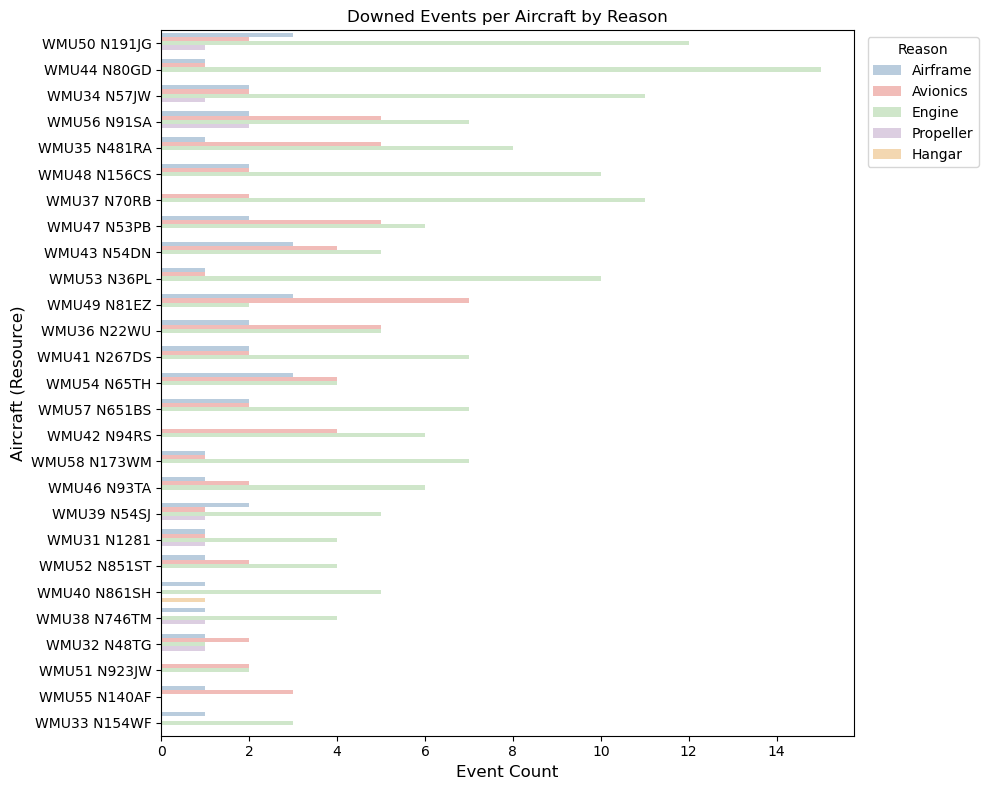

In [16]:
def downed_counts_by_aircraft_and_reason(): 
    # Count how many times each aircraft was downed for each reason
    count_df = NOAA_downed_df.groupby(['resource', 'reason']).size().reset_index(name='count')

    # Sort aircraft by total downed events for ordered plotting
    count_df['resource'] = pd.Categorical(count_df['resource'], categories=aircraft_counts.index, ordered=True)

    fig = plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=count_df,
        y='resource',
        x='count',
        hue='reason',
        palette=our_colors,
     #   alpha=0.4
    )

    plt.title("Downed Events per Aircraft by Reason", fontsize=12)
    plt.xlabel("Event Count", fontsize=12)
    plt.ylabel("Aircraft (Resource)", fontsize=12)
    plt.legend(title='Reason', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    return fig

downed_counts_by_aircraft_and_reason();

Use a stacked bar chart instead to make it easier to read.<br>
Seaborn doesn't have a specific stacked bar chart, so we need to build one with Matplotlib


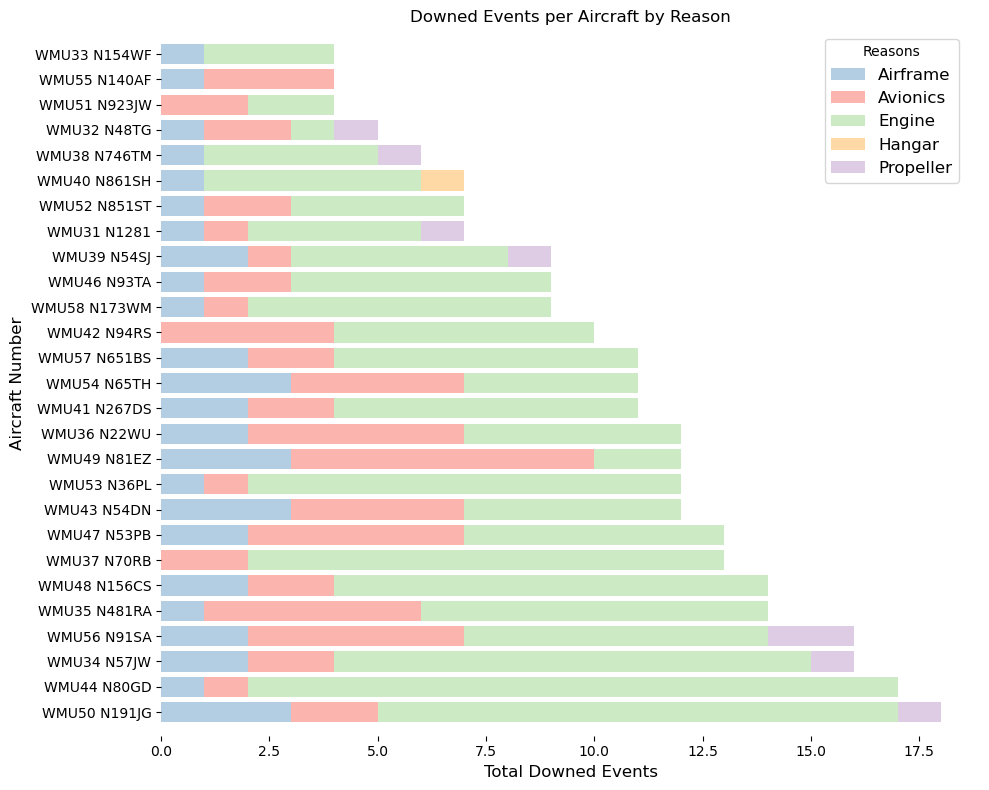

In [17]:
def stacked_downed_counts_by_aircraft_and_reason():
    # Create a pivot table of counts per resource and reason.
    count_df = NOAA_downed_df.groupby(['resource', 'reason']).size().unstack(fill_value=0)

    # Order aircraft by total downed counts using aircraft_counts
    count_df = count_df.loc[aircraft_counts.index]

    fig, ax = plt.subplots(figsize=(10, 8))
    # To build each bar, start at 0 and loop through the reasons to keep the bars in the same order.
    left = pd.Series([0] * len(count_df), index=count_df.index)
    
    for i, reason in enumerate(count_df.columns):
        counts = count_df[reason]
        colors = our_colors.get(reason)
        ax.barh(count_df.index, 
                counts, 
                left=left, 
                label=reason, 
                color=colors,
          #      alpha=0.4,
          #      linewidth=2
               )
        left += counts

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    

    ax.set_xlabel("Total Downed Events", fontsize=12)
    ax.set_ylabel("Aircraft Number", fontsize=12)
    ax.margins(y=0.02)
    ax.set_title("Downed Events per Aircraft by Reason", fontsize=12)
    ax.legend(title='Reasons', bbox_to_anchor=(.8, 1), loc='upper left', fontsize=12)

    plt.tight_layout()
    return fig
stacked_downed_counts_by_aircraft_and_reason();

## Take a look at durations of downed events
Make a horizontal bar chart with Seaborn's **barplot**

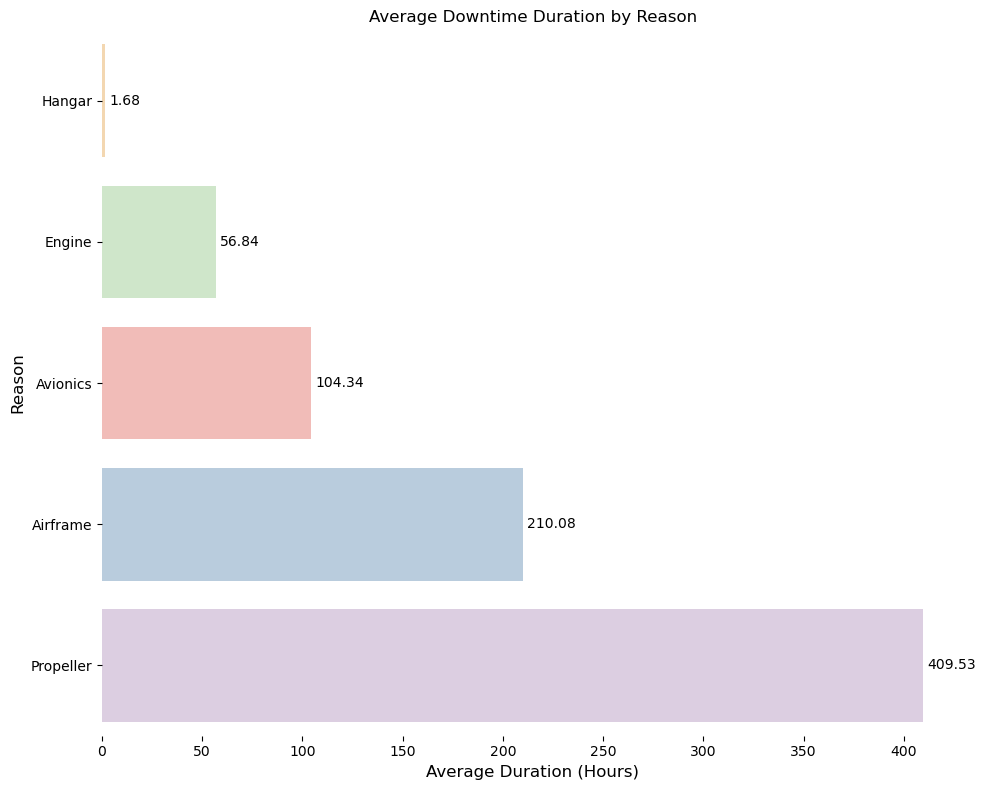

In [18]:
def downtime_barchart():
    #find the average duration time for each reason then convert the time back to hours for simplicity
    avg_duration = NOAA_downed_df.groupby('reason')['duration'].mean().reset_index()
    avg_duration['duration_hours'] = avg_duration['duration'].dt.total_seconds() / 3600

    # Order the duration time from shortes to longest
    plot_data = avg_duration.sort_values('duration_hours', ascending=True)
        
    fig, ax = plt.subplots(figsize=(10, 8))
    barplot = sns.barplot(
        data=plot_data,
        y='reason',
        x='duration_hours',
        palette=our_colors
    )
    
    for i in barplot.containers:
        # Add labels to each bar shown to 2 decimals
        barplot.bar_label(
            i,
            fmt='%.2f',
            label_type='edge',
            padding=3,
        )
    
    # Remove the chart box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)   
    
    plt.title('Average Downtime Duration by Reason', fontsize=12)
    plt.xlabel('Average Duration (Hours)', fontsize=12)
    plt.ylabel('Reason', fontsize=12)
    plt.tight_layout()

    return fig
downtime_barchart();

### Define a function that will save the desired charts to a folder in the Jupyter workspace

In [19]:
# Use this to save any of the above charts by calling its function.
save_dir = "Charts" 

def save_plots(filename):    
    path = os.path.join(save_dir, f"{filename}.png")
    fig = plt.gcf()
    fig.savefig(path, dpi=300,bbox_inches='tight')
    plt.close(fig)


In [20]:
#Plots to save:

# plot_kde_grid()
# downtime_barchart(downed_df)
# stacked_downed_counts_by_aircraft_and_reason()

Plot and save **plot_kde_grid**

In [24]:
# uncomment to run

# plot_kde_grid()
# save_plots('kde_grid')

Plot and save **downtime_barchart(downed_df)**

In [25]:
# uncomment to run

# downtime_barchart()
# save_plots('downtime_barchart')

Plot and save **downed_counts_by_aircraft_and_reason()**

In [28]:
# uncomment to run

# stacked_downed_counts_by_aircraft_and_reason()
# save_plots('stacked_downed_counts_by_aircraft_and_reason')